In [1]:
import pandas as pd

df = pd.read_csv('cleaned_vers_data_covid19_vaccine_2020-2022_duplicate_removed.csv', encoding='latin-1')


C:\Users\rutub\AppData\Local\Temp\ipykernel_14204\2592829857.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_vers_data_covid19_vaccine_2020-2022_duplicate_removed.csv', encoding='latin-1')


In [2]:
# Extract the specified columns
columns = ['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'OFC_VISIT', 'ER_ED_VISIT', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES', 'VAX_MANU', 'Symptoms']
df = df[columns]

# Display the extracted columns
df.head()

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,HOSPITAL,DISABLE,OFC_VISIT,ER_ED_VISIT,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_MANU,Symptoms
0,902418,56.0,F,N,N,N,N,N,N,latex,none,none,none,PFIZER\BIONTECH,"Hypoaesthesia, Injection site hypoaesthesia"
1,902440,35.0,F,N,N,N,N,N,N,No medication,Not applicable,No concerns,N,PFIZER\BIONTECH,Headache
2,902446,55.0,F,N,N,N,N,N,N,"Novasc, Hydrochlorothiazide, synthroid, lisino...",none,"Hypertension, sleep apnea, hypothyroidism","Contrast Dye IV contrast, shellfish, strawberry",PFIZER\BIONTECH,"Erythema, Feeling hot, Flushing"
3,902464,42.0,M,N,N,N,N,N,Y,none,none,none,none,PFIZER\BIONTECH,"Dizziness, Electrocardiogram normal, Hyperhidr..."
4,902465,60.0,F,N,N,N,N,N,N,"Lisinopril, HCTZ, lipitor, amyitrypline, lexap...","Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",Biaxin,PFIZER\BIONTECH,"Dysgeusia, Sensory disturbance, Oral pruritus,..."


## Age grouping

In [3]:
def map_age_group(age):
    if age >= 0 and age <= 10:
        return 'AG1'
    elif age >= 11 and age <= 20:
        return 'AG2'
    elif age >= 21 and age <= 30:
        return 'AG3'
    elif age >= 31 and age <= 40:
        return 'AG4'
    elif age >= 41 and age <= 50:
        return 'AG5'
    elif age >= 51 and age <= 60:
        return 'AG6'
    elif age >= 61 and age <= 70:
        return 'AG7'
    elif age >= 71 and age <= 80:
        return 'AG8'
    elif age >= 81 and age <= 90:
        return 'AG9'
    elif age >= 91 and age <= 100:
        return 'AG10'
    else:
        return 'AGN'  # Default age group for values outside the specified ranges

df['AGE_GROUP'] = df['AGE_YRS'].apply(map_age_group)
df = df.drop('AGE_YRS', axis=1)

## Modifying the database to lower string and remove unwanted values

In [4]:
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

df.loc[df['OTHER_MEDS'].str.startswith(('none', 'None', 'NONE', 'NOS', 'not', 'no', 'Not', 'na', 'NO', 'NOT', 'unknown', 'Unknown')), 'OTHER_MEDS'] = 'no medication'
df.loc[df['CUR_ILL'].str.startswith(('none', 'None', 'NONE', 'NOS', 'not', 'no', 'Not', 'na', 'NO', 'NOT', 'No', 'negative', 'non', 'Non', 'Nothing', 'nothing', 'unknown', 'Unknown')), 'CUR_ILL'] = 'not applicable'
df.loc[df['HISTORY'].str.startswith(('none', 'None', 'NONE', 'NOS', 'not', 'no', 'Not', 'na', 'NO', 'NOT', 'No', 'negative', 'non', 'Non', 'Nothing', 'nothing', 'unknown', 'Unknown')), 'HISTORY'] = 'no concerns'
df.loc[df['ALLERGIES'].str.startswith(('none', 'None', 'NONE', 'NOS', 'not', 'no', 'Not', 'na', 'NO', 'NOT', 'No', 'negative', 'non', 'Non', 'Nothing', 'nothing', 'nka', 'nkda', 'NKA', 'NKDA', 'unknown', 'Unknown', 'n')), 'ALLERGIES'] = 'no allergies'

## Seperating dataframe into 4 different dataframes

In [5]:
pfizer_biontech_df = df[df['VAX_MANU'] == 'pfizer\\biontech']
unknown_manufacturer_df = df[df['VAX_MANU'] == 'unknown manufacturer']
moderna_df = df[df['VAX_MANU'] == 'moderna']
janssen_df = df[df['VAX_MANU'] == 'janssen']

## Running apriori on Moderna vaccine

In [6]:
symptom_categories = {
    'headache': 'pain',
    'pyrexia': 'fever',
    'fatigue': 'discomfort',
    'chills': 'fever',
    'pain': 'pain',
    'dizziness': 'disorientation',
    'nausea': 'discomfort',
    'pain in extremity': 'pain',
    'injection site pain': 'pain',
    'arthralgia': 'pain',
    'myalgia': 'pain',
    'dyspnoea': 'breathing difficulty',
    'rash': 'skin condition',
    'injection site erythema': 'skin reaction',
    'pruritus': 'itching',
    'injection site swelling': 'skin reaction',
    'vomiting': 'discomfort',
    'asthenia': 'weakness',
    'hyperhidrosis': 'excessive sweating',
    'injection site pruritus': 'skin reaction',
    'erythema': 'skin condition',
    'paraesthesia': 'abnormal sensation',
    'diarrhoea': 'digestive issue',
    'hypoaesthesia': 'sensory issue',
    'urticaria': 'skin condition',
    'chest pain': 'pain',
    'feeling abnormal': 'discomfort',
    'lymphadenopathy': 'enlarged lymph nodes',
    'cough': 'respiratory issue',
    'malaise': 'discomfort',
    'injection site warmth': 'skin reaction',
    'peripheral swelling': 'swelling',
    'syncope': 'fainting',
    'chest discomfort': 'pain',
    'blood test': 'medical test',
    'tremor': 'shaking',
    'palpitations': 'heart issue',
    'tinnitus': 'sensory issue',
    'injection site rash': 'skin reaction',
    'heart rate increased': 'heart issue',
    'back pain': 'pain',
    'condition aggravated': 'worsened condition',
    'electrocardiogram': 'heart test',
    'feeling hot': 'temperature sensitivity',
    'decreased appetite': 'appetite issue',
    'rash erythematous': 'skin condition',
    'loss of consciousness': 'fainting',
    'swelling': 'swelling',
    'neck pain': 'pain',
    'skin warm': 'temperature sensitivity',
    'oropharyngeal pain': 'throat pain',
    'mobility decreased': 'movement issue',
    'rash pruritic': 'itching',
    'flushing': 'skin redness',
    'sleep disorder': 'sleep issue',
    'migraine': 'pain',
    'laboratory test': 'medical test',
    'computerised tomogram': 'medical imaging',
    'death': 'severe outcome',
    'muscle spasms': 'muscle issue',
    'vertigo': 'dizziness',
    'full blood count': 'blood test',
    'fall': 'accident',
    'anxiety': 'mental health',
    'inappropriate schedule of product administration': 'administration issue',
    'body temperature increased': 'temperature change',
    'muscular weakness': 'weakness',
    'lethargy': 'fatigue',
    'insomnia': 'sleep issue',
    'vaccination site pain': 'pain',
    'chest x-ray': 'medical imaging',
    'abdominal pain upper': 'abdominal pain',
    'abdominal pain': 'abdominal pain',
    'impaired work ability': 'work-related issue',
    'swelling face': 'facial swelling',
    'feeling cold': 'temperature sensitivity',
    'vision blurred': 'vision issue',
    'burning sensation': 'sensory issue',
    'metabolic function test': 'medical test',
    'immediate post-injection reaction': 'reaction',
    'herpes zoster': 'viral infection',
    'musculoskeletal stiffness': 'muscle issue',
    'pallor': 'skin color issue',
    'throat tightness': 'throat issue',
    'paraesthesia oral': 'sensory issue',
    'hypertension': 'blood pressure issue',
    'extra dose administered': 'administration issue',
    'rhinorrhoea': 'nasal issue',
    'blood pressure increased': 'blood pressure issue',
    'incorrect dose administered': 'administration issue',
    'tachycardia': 'heart issue',
    'magnetic resonance imaging': 'medical imaging',
    'injection site induration': 'skin reaction',
    'confusional state': 'mental confusion',
    'interchange of vaccine products': 'administration issue',
    'somnolence': 'drowsiness',
    'throat irritation': 'throat issue',
    'axillary pain': 'pain',
    'blood test normal': 'medical test',
    'unresponsive to stimuli': 'unresponsiveness',
    'echocardiogram': 'heart test',
    'abdominal discomfort': 'abdominal issue',
    'loss of personal independence in daily activities': 'functionality loss',
    'tenderness': 'sensitivity',
    'lip swelling': 'facial swelling',
    'injection site reaction': 'skin reaction',
    'lymph node pain': 'pain',
    'dysphagia': 'swallowing issue',
    'seizure': 'neurological issue',
    'nasal congestion': 'nasal issue',
    'hypoaesthesia oral': 'sensory issue',
    'heavy menstrual bleeding': 'menstrual issue',
    'ageusia': 'taste issue',
}

def process_meds(row):
    apriori_list = []

    for symptom, replacement in symptom_categories.items():
        if symptom in row['Symptoms']:
            apriori_list.append(replacement)

    if 'y' in str(row['OFC_VISIT']) or 'y' in str(row['ER_ED_VISIT']) or 'y' in str(row['HOSPITAL']) or 'y' in str(row['DIED']):
        apriori_list.append("Saught medical care")

    if row['VAX_MANU'] == 'moderna':
        apriori_list.append('Moderna vaccine')
    
    # if row['AGE_GROUP'] == 'AG1' or row['AGE_GROUP'] == 'AG2':
    #     apriori_list.append('Age 0-20')
    # elif row['AGE_GROUP'] == 'AG3' or row['AGE_GROUP'] == 'AG4':
    #     apriori_list.append('Age 21-40')
    # elif row['AGE_GROUP'] == 'AG5' or row['AGE_GROUP'] == 'AG6':
    #     apriori_list.append('Age 41-60')
    # elif row['AGE_GROUP'] == 'AG7' or row['AGE_GROUP'] == 'AG8':
    #     apriori_list.append('Age 61-80')
    # elif row['AGE_GROUP'] == 'AG9' or row['AGE_GROUP'] == 'AG10':
    #     apriori_list.append('Age 81-100')

    return apriori_list if apriori_list else ['ignore']

moderna_df['MODERNA_APRIORI_LIST'] = moderna_df.apply(process_meds, axis=1)

C:\Users\rutub\AppData\Local\Temp\ipykernel_14204\2436800875.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moderna_df['MODERNA_APRIORI_LIST'] = moderna_df.apply(process_meds, axis=1)


In [7]:
from apyori import apriori

transactions = moderna_df.groupby('VAERS_ID')['MODERNA_APRIORI_LIST'].apply(lambda x: [item for sublist in x for item in sublist]).tolist()

results = list(apriori(transactions, min_support=0.1, min_confidence=0.1, min_length=2, max_length=6))

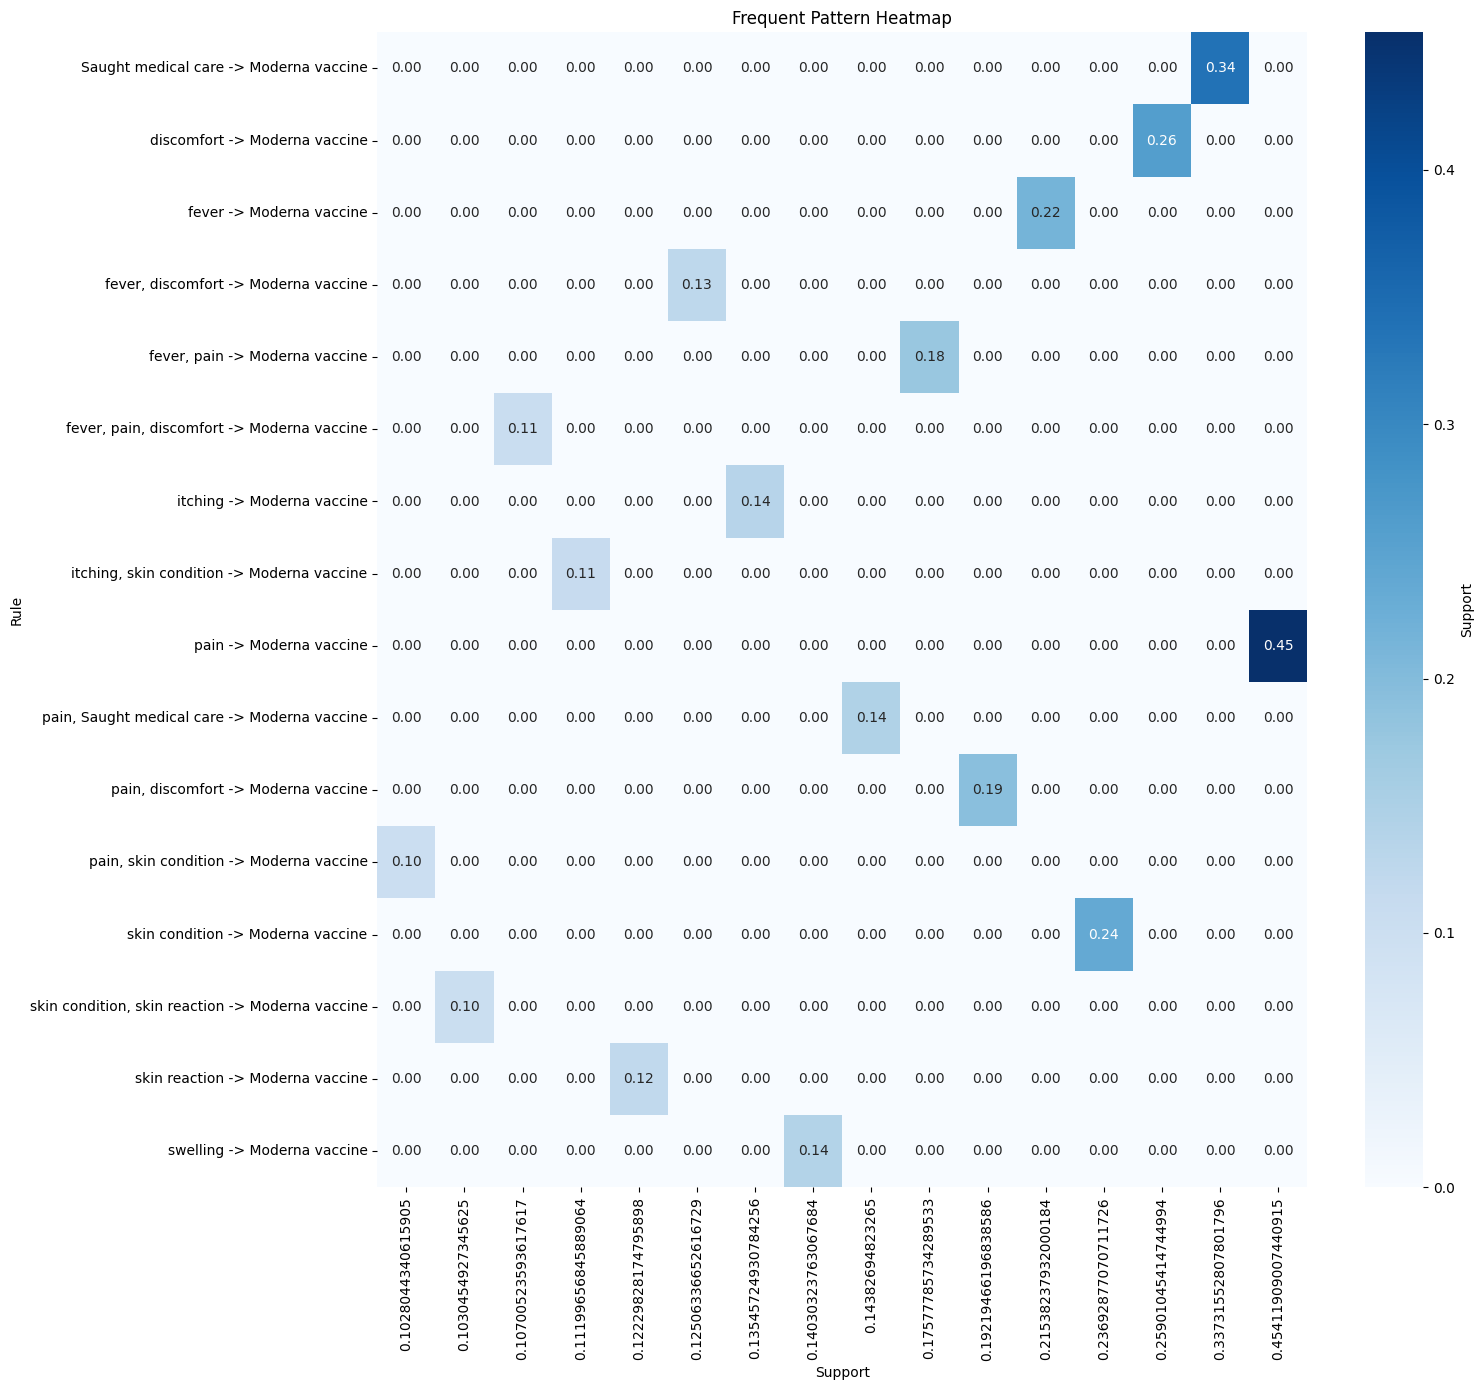

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_rules(apriori_result):
    rules = []
    supports = []
    for relation_record in apriori_result:
        for ordered_statistic in relation_record.ordered_statistics:
            antecedent = list(ordered_statistic.items_base)
            consequent = list(ordered_statistic.items_add)
            support = relation_record.support

            # Check if 'Moderna vaccine' is in antecedent or consequent
            if 'Moderna vaccine' in consequent and len(consequent) == 1:
                if antecedent and consequent:  # Exclude if either antecedent or consequent is empty
                    rule = ', '.join(antecedent) + ' -> ' + ', '.join(consequent)
                    rules.append(rule)
                    supports.append(support)
    return rules, supports

# Extract rules and support values
extracted_rules, support_values = extract_rules(results)

# Create a DataFrame with rules and support values
rules_df = pd.DataFrame({'Rules': extracted_rules, 'Support': support_values})

# Pivot the DataFrame for heatmap visualization
pivot_df = rules_df.pivot(index='Rules', columns='Support', values='Support').fillna(0)

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_df, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Support'})
plt.title('Frequent Pattern Heatmap')
plt.xlabel('Support')
plt.ylabel('Rule')
plt.show()


## Running apriori on Pfizer vaccine

In [9]:
def process_meds(row):
    apriori_list = []

    for symptom, replacement in symptom_categories.items():
        if symptom in row['Symptoms']:
            apriori_list.append(replacement)

    if 'y' in str(row['OFC_VISIT']) or 'y' in str(row['ER_ED_VISIT']) or 'y' in str(row['HOSPITAL']) or 'y' in str(row['DIED']):
        apriori_list.append("Saught medical care")

    if row['VAX_MANU'] == 'pfizer\\biontech':
        apriori_list.append('Pfizer vaccine')
    
    return apriori_list if apriori_list else ['ignore']

pfizer_biontech_df['MODERNA_APRIORI_LIST'] = pfizer_biontech_df.apply(process_meds, axis=1)

C:\Users\rutub\AppData\Local\Temp\ipykernel_17808\2393348129.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfizer_biontech_df['PFIZER_APRIORI_LIST'] = pfizer_biontech_df.apply(process_meds, axis=1)


In [28]:
from apyori import apriori

transactions = pfizer_biontech_df.groupby('VAERS_ID')['PFIZER_APRIORI_LIST'].apply(lambda x: [item for sublist in x for item in sublist]).tolist()

results = list(apriori(transactions, min_support=0.1, min_confidence=0.1, min_length=2, max_length=6))

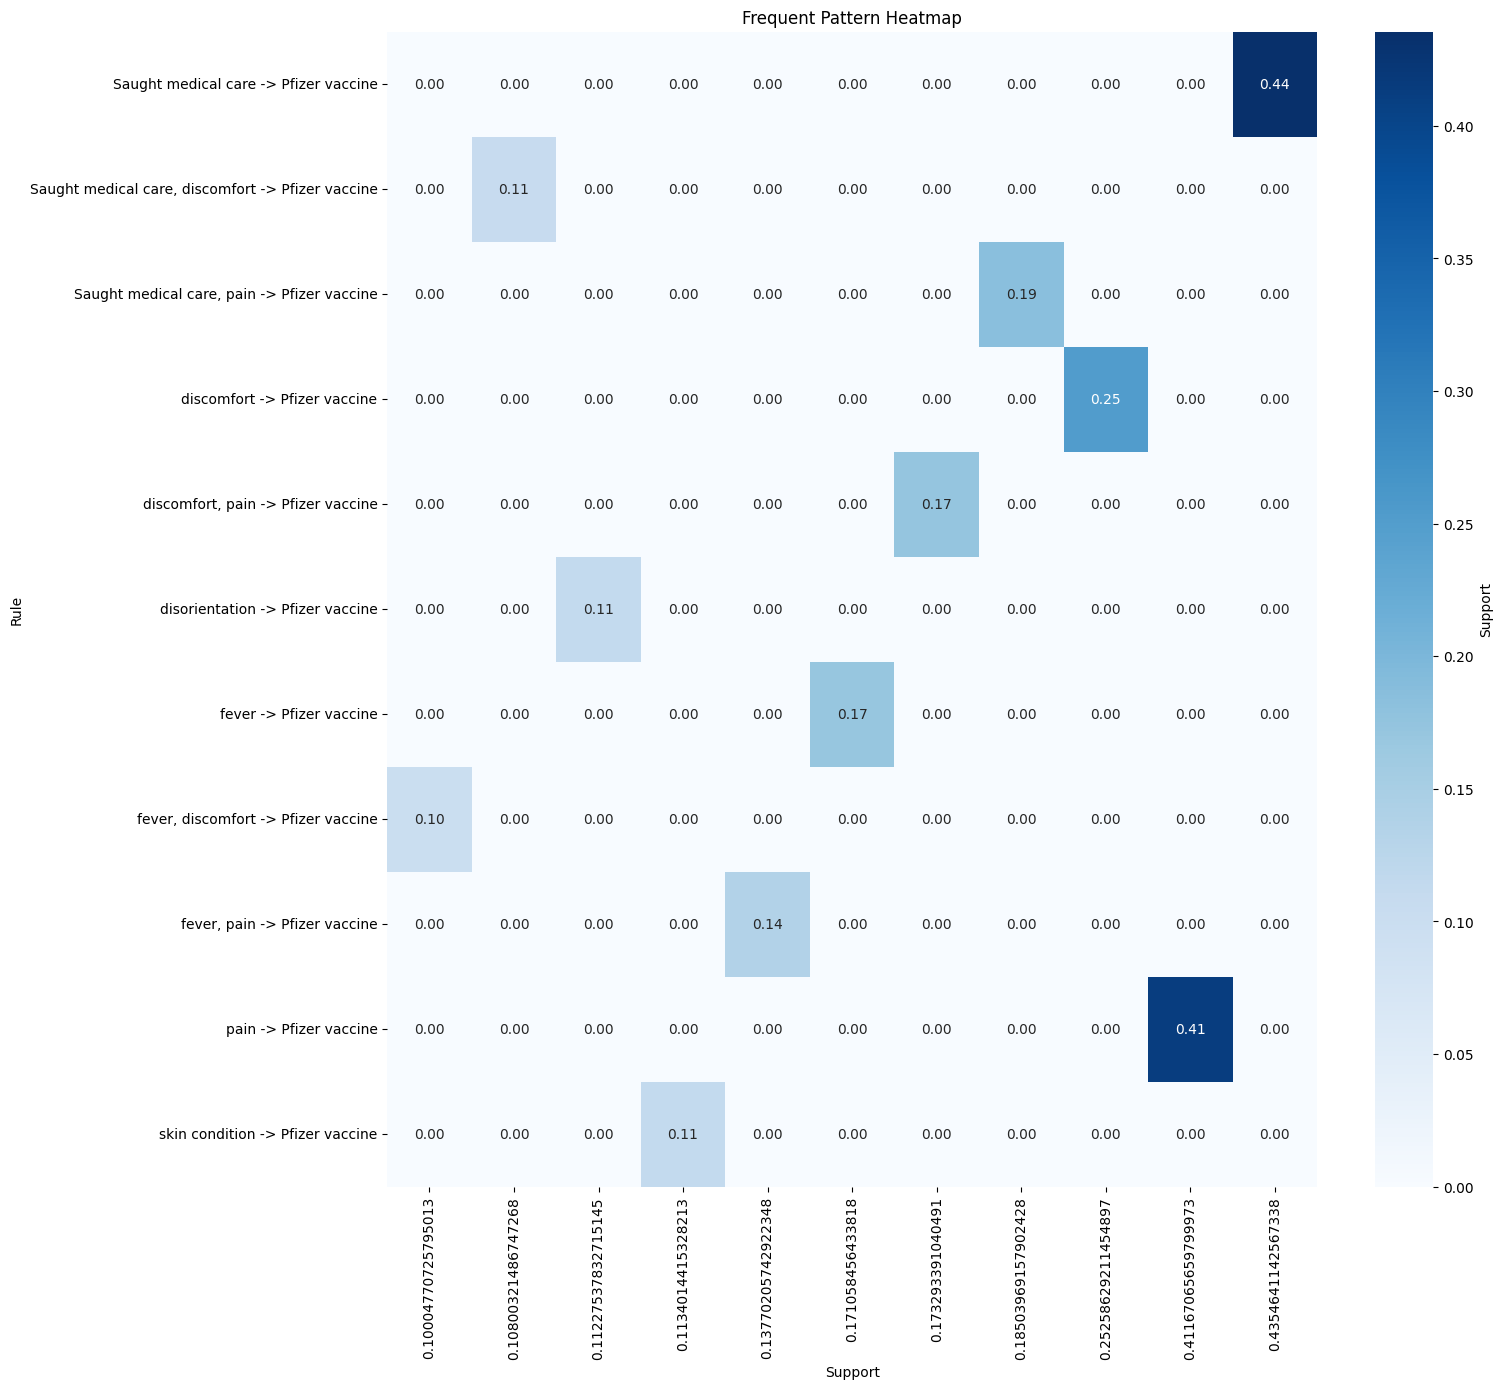

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_rules(apriori_result):
    rules = []
    supports = []
    for relation_record in apriori_result:
        for ordered_statistic in relation_record.ordered_statistics:
            antecedent = list(ordered_statistic.items_base)
            consequent = list(ordered_statistic.items_add)
            support = relation_record.support

            # Check if 'Moderna vaccine' is in antecedent or consequent
            if 'Pfizer vaccine' in consequent and len(consequent) == 1:
                if antecedent and consequent:  # Exclude if either antecedent or consequent is empty
                    rule = ', '.join(antecedent) + ' -> ' + ', '.join(consequent)
                    rules.append(rule)
                    supports.append(support)
    return rules, supports

# Extract rules and support values
extracted_rules, support_values = extract_rules(results)

# Create a DataFrame with rules and support values
rules_df = pd.DataFrame({'Rules': extracted_rules, 'Support': support_values})

# Pivot the DataFrame for heatmap visualization
pivot_df = rules_df.pivot(index='Rules', columns='Support', values='Support').fillna(0)

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_df, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Support'})
plt.title('Frequent Pattern Heatmap')
plt.xlabel('Support')
plt.ylabel('Rule')
plt.show()


## Running apriori on Janssen vaccine

In [12]:
def process_meds(row):
    apriori_list = []

    for symptom, replacement in symptom_categories.items():
        if symptom in row['Symptoms']:
            apriori_list.append(replacement)

    if 'y' in str(row['OFC_VISIT']) or 'y' in str(row['ER_ED_VISIT']) or 'y' in str(row['HOSPITAL']) or 'y' in str(row['DIED']):
        apriori_list.append("Saught medical care")

    if row['VAX_MANU'] == 'janssen':
        apriori_list.append('Janssen vaccine')
    
    return apriori_list if apriori_list else ['ignore']

janssen_df['JANSSEN_APRIORI_LIST'] = janssen_df.apply(process_meds, axis=1)

C:\Users\rutub\AppData\Local\Temp\ipykernel_17808\265285855.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  janssen_df['JANSSEN_APRIORI_LIST'] = janssen_df.apply(process_meds, axis=1)


In [13]:
from apyori import apriori

transactions = janssen_df.groupby('VAERS_ID')['JANSSEN_APRIORI_LIST'].apply(lambda x: [item for sublist in x for item in sublist]).tolist()

results = list(apriori(transactions, min_support=0.1, min_confidence=0.1, min_length=2, max_length=6))

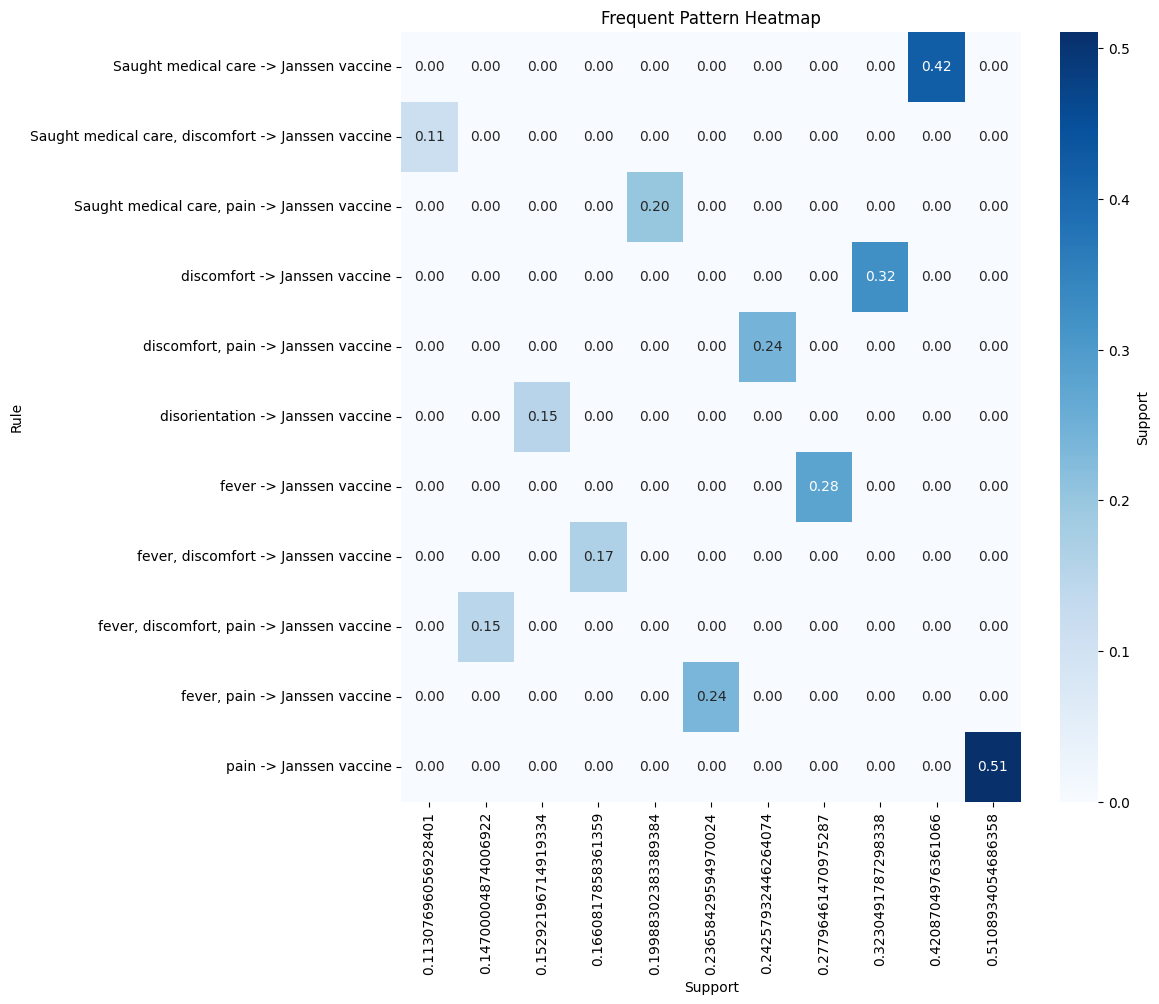

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_rules(apriori_result):
    rules = []
    supports = []
    for relation_record in apriori_result:
        for ordered_statistic in relation_record.ordered_statistics:
            antecedent = list(ordered_statistic.items_base)
            consequent = list(ordered_statistic.items_add)
            support = relation_record.support

            # Check if 'Moderna vaccine' is in antecedent or consequent
            if 'Janssen vaccine' in consequent and len(consequent) == 1:
                if antecedent and consequent:  # Exclude if either antecedent or consequent is empty
                    rule = ', '.join(antecedent) + ' -> ' + ', '.join(consequent)
                    rules.append(rule)
                    supports.append(support)
    return rules, supports

# Extract rules and support values
extracted_rules, support_values = extract_rules(results)

# Create a DataFrame with rules and support values
rules_df = pd.DataFrame({'Rules': extracted_rules, 'Support': support_values})

# Pivot the DataFrame for heatmap visualization
pivot_df = rules_df.pivot(index='Rules', columns='Support', values='Support').fillna(0)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_df, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Support'})
plt.title('Frequent Pattern Heatmap')
plt.xlabel('Support')
plt.ylabel('Rule')
plt.show()


## Running apriori on all vaccine type together

In [16]:
def process_meds(row):
    apriori_list = []

    for symptom, replacement in symptom_categories.items():
        if symptom in row['Symptoms']:
            apriori_list.append(replacement)

    if 'y' in str(row['OFC_VISIT']) or 'y' in str(row['ER_ED_VISIT']) or 'y' in str(row['HOSPITAL']) or 'y' in str(row['DIED']):
        apriori_list.append("Saught medical care")

    if row['VAX_MANU'] == 'janssen':
        apriori_list.append('Janssen vaccine')
    
    if row['VAX_MANU'] == 'pfizer\\biontech':
        apriori_list.append('Pfizer vaccine')
    
    if row['VAX_MANU'] == 'moderna':
        apriori_list.append('Moderna vaccine')
        
    return apriori_list if apriori_list else ['ignore']

df['ALL_VACCINE_APRIORI_LIST'] = df.apply(process_meds, axis=1)

In [25]:
from apyori import apriori

transactions = df.groupby('VAERS_ID')['ALL_VACCINE_APRIORI_LIST'].apply(lambda x: [item for sublist in x for item in sublist]).tolist()

results = list(apriori(transactions, min_support=0.1, min_confidence=0.1, min_length=2, max_length=6))

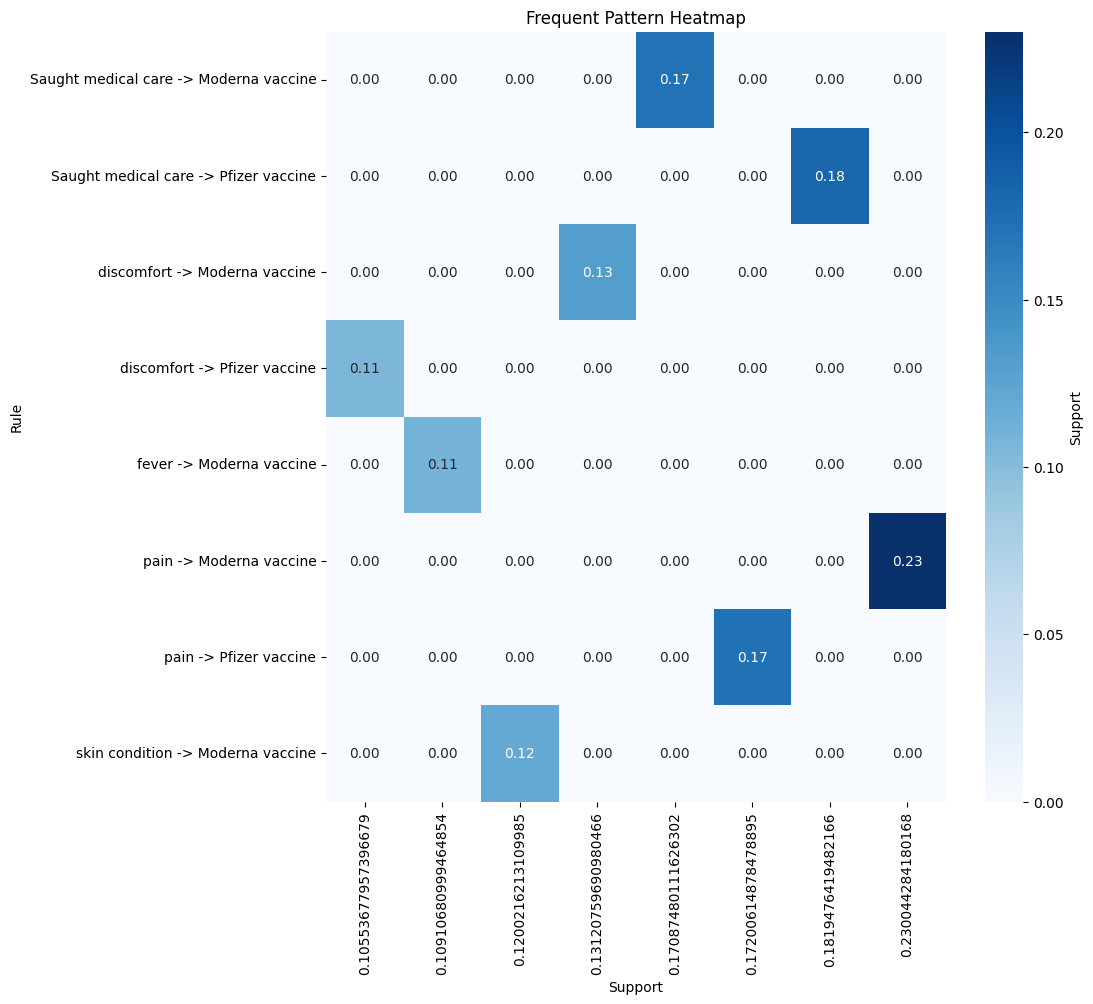

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def extract_rules(apriori_result):
    rules = []
    supports = []
    for relation_record in apriori_result:
        for ordered_statistic in relation_record.ordered_statistics:
            antecedent = list(ordered_statistic.items_base)
            consequent = list(ordered_statistic.items_add)
            support = relation_record.support

            # Check if 'Moderna vaccine' is in antecedent or consequent
            if 'Pfizer vaccine' in consequent or 'Moderna vaccine' in consequent or 'Janssen vaccine' in consequent:
                if antecedent and consequent:  # Exclude if either antecedent or consequent is empty
                    rule = ', '.join(antecedent) + ' -> ' + ', '.join(consequent)
                    rules.append(rule)
                    supports.append(support)
    return rules, supports

# Extract rules and support values
extracted_rules, support_values = extract_rules(results)

# Create a DataFrame with rules and support values
rules_df = pd.DataFrame({'Rules': extracted_rules, 'Support': support_values})

# Pivot the DataFrame for heatmap visualization
pivot_df = rules_df.pivot(index='Rules', columns='Support', values='Support').fillna(0)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_df, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': 'Support'})
plt.title('Frequent Pattern Heatmap')
plt.xlabel('Support')
plt.ylabel('Rule')
plt.show()


## Applying apriori on 